In [1]:
import glob
import os
import cv2
import glob
import importlib
import h5py
import json
import copy
import _pickle as pkl
import numpy as np
import pandas as pd
import seaborn as sns
import pylab as pl
import matplotlib as mpl
import scipy.stats as spstats

In [2]:
import analyze2p.utils as hutils
import analyze2p.plotting as pplot

import analyze2p.receptive_fields.utils as rfutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.extraction.rois as roiutils
import analyze2p.retinotopy.utils as retutils
import analyze2p.retinotopy.segment as seg
import analyze2p.gradients as grd

In [3]:
rootdir = '/n/coxfs01/2p-data'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
traceid='traces001'

In [4]:
# Metadata
visual_areas=['V1', 'Lm', 'Li']
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
meta = sdata[sdata.experiment.isin(['rfs', 'rfs10'])].copy()

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets


In [5]:
# Receptive Field settings
experiment='rfs'
response_type='dff'

meta['session_int'] = meta['session'].astype(int)

dsets = meta[(meta.experiment==experiment) & (meta.visual_area.isin(['V1', 'Lm']))
            & (meta['session_int']>=20190511)].copy()


## Select dataset and create output dirs

In [6]:
dk = '20190617_JC097_fov1'
va = 'V1'

## Select parameters

In [7]:
# RF settings
is_neuropil=True
do_spherical_correction=False
fit_thr=0.5

In [8]:
basedir = os.path.join(aggregate_dir, 'receptive-fields', 'neuropil')

target_sigma_um=20
desired_radius_um=20
smooth_spline_x=1
smooth_spline_y=1
create_new=False
redo_smooth=True
is_neuropil=True
ds_factor=1

In [9]:
#### Some plotting stuff
scatter_kws={'s':2}

# Do it

#### Select output dirs

In [10]:
session, animalid, fovn = hutils.split_datakey_str(dk)
fovdir = glob.glob(os.path.join(rootdir, animalid, session, 'FOV%i_*' % fovn))[0]
curr_dst_dir = os.path.join(fovdir, 'segmentation')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/segmentation


#### Load NEUROPIL BACKGROUND

In [34]:
importlib.reload(grd)

<module 'analyze2p.gradients' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/gradients.py'>

#### Load (or calculate) segmentation results

In [35]:
retinorun = grd.get_best_retinorun(dk)
print(dk, retinorun)
gresults = grd.load_gradients(dk, va, retinorun, create_new=True)

20190617_JC097_fov1 retino_run1
dict_keys(['V1', 2])


In [39]:
grad_az = gresults['az_gradients']
grad_el = gresults['el_gradients']
AZMAP_NP = grad_az['image']
ELMAP_NP = grad_el['image']
GVECTORS = {'az': grad_az['vhat'], 'el': grad_el['vhat']}

#### Calculate gradient vectors

In [40]:
%matplotlib notebook

<IPython.core.display.Javascript object>


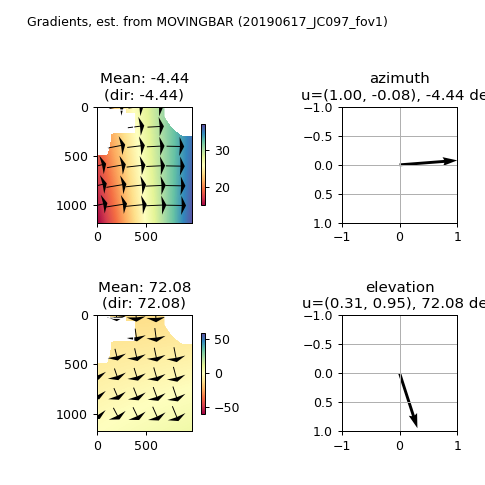

/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/segmentation


In [41]:
#### Plot gradients
spacing =200
scale = 0.0001 #0.0001
width = 0.01 #1 #0.01
headwidth=20
contour_lc='w'
contour_lw=1
cmap ='Spectral'
fig = seg.plot_gradients_in_area(curr_area_mask, AZMAP_NP, ELMAP_NP, 
                             grad_az, grad_el, cmap_phase=cmap,
                             contour_lc=contour_lc, contour_lw=contour_lw, 
                             spacing=spacing, 
                             scale=scale, width=width, headwidth=headwidth)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, hspace=0.8, top=0.8)
fig.text(0.05, 0.95, 'Gradients, est. from MOVINGBAR (%s)' % dk)

pl.savefig(os.path.join(curr_dst_dir, 'np_gradients.svg'))
print(curr_dst_dir)

#### Load Neuropil data points

In [229]:
mag_thr=0.001
delay_map_thr=1.0
ds_factor=2
retinodf_np = grd.get_neuropil_data(dk, retinorun, mag_thr=mag_thr, 
                                delay_map_thr=delay_map_thr, ds_factor=ds_factor)
if plot_measured:
    #### Plot MEASURED ctx on ret pos
    fig = grd.scatter_ctx_vs_retino_by_cond(retinodf_np, 
                                 az_x='ml_pos', az_y='x0', 
                                 el_x='ap_pos', el_y='y0',
                                 xlabel='meas. CTX pos (um)', 
                                 ylabel='meas. RET pos (deg)')
    fig.text(0.01, 0.95, 'BAR-estimated neuropil prefs. (%s)' % dk, fontsize=8)
    figname = 'measured_ctx_vs_ret_BAR'
    pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
    print(curr_dst_dir, figname)

DATA ID: 20190617_JC097_fov1_retino_run1_analysis002
Original dims: [512, 512]
Data were downsampled by 2.
256 256
Adding ROI position info...


#### Use NEUROPIL to estimate linear model

In [231]:
plot_aligned=False
# 1. Align FOV to gradient vector direction ***FIX THIS TO REPLACE W TRANSMAT
aligned_, M = grd.align_cortex_to_gradient(retinodf_np, GVECTORS,
                                  xlabel='ml_pos', ylabel='ap_pos')
aligned_np = pd.concat([retinodf_np, aligned_], axis=1).dropna()
if plot_aligned:
    # PLOT POST-alignment (should be better)
    fig = grd.scatter_ctx_vs_retino_by_cond(aligned_np, 
                                 az_x='ml_proj', az_y='x0', 
                                 el_x='ap_proj', el_y='y0',
                                 xlabel='aligned CTX pos (um)', 
                                 ylabel='meas. RET pos (deg)')
    fig.text(0.01, 0.95, 'MOVINGBAR-estimated neuropil prefs. (%s)' % dk, fontsize=8)
    figname = 'aligned_ctx_vs_measured_ret_BAR'
    pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
    print(curr_dst_dir, figname)

In [276]:
# 2. Fit model
REGR_NP = grd.regress_cortex_and_retino_pos(aligned_np, xvar='proj', model='ridge')
regr_np_meas = grd.regress_cortex_and_retino_pos(aligned_np, xvar='pos', model='ridge')
# Save
grd.update_models(dk, va, REGR_NP)

Measured ctx to y0: r=0.916 (p=0.000)
Aligned ctx to y0: r=0.960 (p=0.000)


<IPython.core.display.Javascript object>


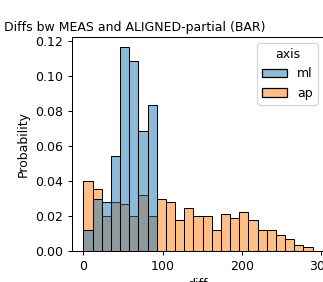

Text(0.01, 0.9, 'Diffs bw MEAS and ALIGNED-partial (BAR)')

In [182]:
hist_diffs=False
if hist_diffs:
    r0, p0 = spstats.pearsonr(aligned_np['y0'].values, aligned_np['ap_pos'].values)
    r1, p1 = spstats.pearsonr(aligned_np['y0'].values, aligned_np['ap_proj'].values)
    print('Measured ctx to y0: r=%.3f (p=%.3f)' % (r0, p0))
    print('Aligned ctx to y0: r=%.3f (p=%.3f)' % (r1, p1))

    diffs_ml = aligned_np['ml_pos'].round(2)-aligned_np['ml_proj'].round(2)
    diffs_ap = aligned_np['ap_pos'].round(2)-aligned_np['ap_proj'].round(2)
    diffs_true_proj = pd.DataFrame({'ml': diffs_ml.abs(), 'ap': diffs_ap.abs()})
    diffs_ = diffs_true_proj.stack().reset_index()\
                .rename(columns={'level_1': 'axis', 0: 'diff'})

    fig, ax = pl.subplots(figsize=(4,3.5))
    sns.histplot(diffs_, x='diff', hue='axis', ax=ax, stat='probability', 
                 common_norm=True, common_bins=True)
    pl.subplots_adjust(left=0.2, bottom=0.2)
    fig.text(0.01, 0.9, 'Diffs bw MEAS and ALIGNED-partial (BAR)')

In [ ]:
# Save/update regression results 

# def load_models(dk, va, rootdir='/n/coxfs01/2p-data'):
#     REGR_NP=None
#     try:
#         session, animalid, fovn = hutils.split_datakey_str(dk)
#         fovdir = glob.glob(os.path.join(rootdir, animalid, session, 'FOV%i_*' % fovn))[0]
#         curr_dst_dir = os.path.join(fovdir, 'segmentation')
#         alignment_fpath = os.path.join(curr_dst_dir, 'alignment.pkl')
#         with open(alignment_fpath, 'rb') as f:
#             regr_results = pkl.load(f)
#         REGR_NP = regr_results[va].copy()
#     except Exception as e:
#         return None
    
#     return REGR_NP

# def update_models(dk, va, REGR_NP, rootdir='/n/coxfs01/2p-data'):
#     session, animalid, fovn = hutils.split_datakey_str(dk)
#     fovdir = glob.glob(os.path.join(rootdir, animalid, session, 'FOV%i_*' % fovn))[0]
#     curr_dst_dir = os.path.join(fovdir, 'segmentation')
#     alignment_fpath = os.path.join(curr_dst_dir, 'alignment.pkl')
#     regr_results={}
#     if os.path.exists(alignment_fpath):
#         with open(alignment_fpath, 'rb') as f:
#             regr_results = pkl.load(f)
#     regr_results.update{va: REGR_NP}
#     with open(alignment_fpath, 'wb') as f:
#         pkl.dump(regr_results, f, protocol=2)
#     return

MEASURED:
|    |       R2 |    RMSE |    pearson_p |   pearson_r |   coefficient |   intercept | cond   |
|---:|---------:|--------:|-------------:|------------:|--------------:|------------:|:-------|
|  0 | 0.919723 | 1.50534 | 8.45967e-234 |    0.959022 |     0.0208337 |     16.4687 | az     |
|  1 | 0.839559 | 1.72494 | 3.55077e-170 |    0.916275 |     0.0148211 |    -13.8915 | el     |
ALIGNED:
|    |       R2 |    RMSE |    pearson_p |   pearson_r |   coefficient |   intercept | cond   |
|---:|---------:|--------:|-------------:|------------:|--------------:|------------:|:-------|
|  0 | 0.931553 | 1.39001 | 1.91233e-248 |    0.96517  |     0.0207571 |     17.7019 | az     |
|  1 | 0.922133 | 1.2017  | 1.34167e-236 |    0.960277 |     0.0161626 |    -16.6297 | el     |


<IPython.core.display.Javascript object>


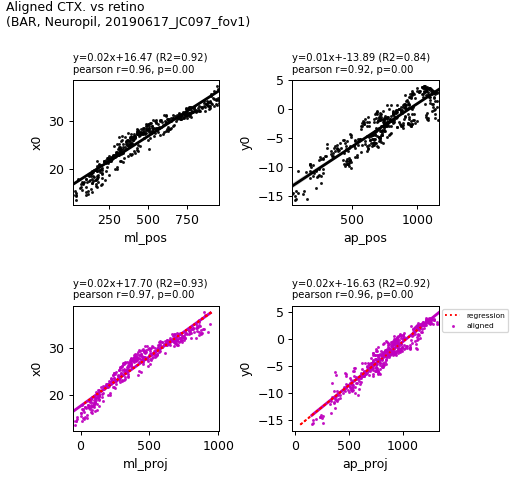

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or mis

Text(0.01, 0.95, 'Aligned CTX. vs retino\n(BAR, Neuropil, 20190617_JC097_fov1)')

In [280]:
# Q:  why is reversal (LM) wonky
# Q:  fit SOMA to eitehr BAR or TILE gradient
print("MEASURED:")
print(regr_np_meas.to_markdown())
print("ALIGNED:")
print(REGR_NP.to_markdown())

fig = grd.plot_measured_and_aligned(aligned_np, REGR_NP, regr_np_meas)
fig.text(0.01, 0.95, 'Aligned CTX. vs retino\n(BAR, Neuropil, %s)' % dk)

#### Load soma

In [211]:
importlib.reload(grd)
%matplotlib notebook

In [234]:
df_soma = grd.get_soma_data(dk, experiment=experiment, retinorun=retinorun, 
                            protocol='TILE', traceid=traceid,
                            response_type=response_type,
                            do_spherical_correction=do_spherical_correction)

Adding ROI position info...


<IPython.core.display.Javascript object>


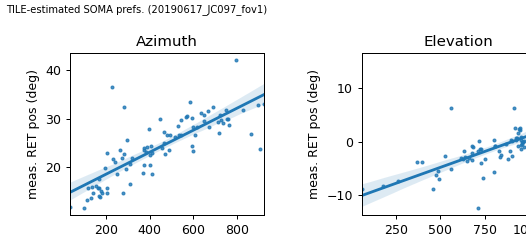

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/segmentation tile_measured_ctx_vs_ret_SOMA


In [235]:
#### PLOT MEASURED soma pos. vs ret pos
fig = grd.scatter_ctx_vs_retino_by_cond(df_soma, 
                                 az_x='ml_pos', az_y='x0', 
                                 el_x='ap_pos', el_y='y0',
                                 xlabel='meas. CTX pos (um)', 
                                 ylabel='meas. RET pos (deg)')
fig.text(0.01, 0.95, 'TILE-estimated SOMA prefs. (%s)' % dk, fontsize=8)
figname = 'tile_measured_ctx_vs_ret_SOMA'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

#### Align soma coords to gradient

In [282]:
aligned_, M = grd.align_cortex_to_gradient(df_soma, GVECTORS,
                                  xlabel='ml_pos', ylabel='ap_pos')
aligned_soma = pd.concat([df_soma, aligned_], axis=1).dropna().reset_index(drop=True)

MEASURED:
|    |       R2 |    RMSE |   pearson_p |   pearson_r |   coefficient |   intercept | cond   |
|---:|---------:|--------:|------------:|------------:|--------------:|------------:|:-------|
|  0 | 0.641557 | 3.83511 | 7.36519e-21 |    0.800972 |     0.0228466 |     13.901  | az     |
|  1 | 0.452836 | 3.09426 | 6.89815e-13 |    0.672931 |     0.0119508 |    -10.8134 | el     |
ALIGNED:
|    |       R2 |    RMSE |   pearson_p |   pearson_r |   coefficient |   intercept | cond   |
|---:|---------:|--------:|------------:|------------:|--------------:|------------:|:-------|
|  0 | 0.641338 | 3.83628 |  7.5616e-21 |    0.800836 |     0.0224299 |     15.5838 | az     |
|  1 | 0.449071 | 3.10489 |  9.3008e-13 |    0.670128 |     0.0127939 |    -12.7496 | el     |


<IPython.core.display.Javascript object>


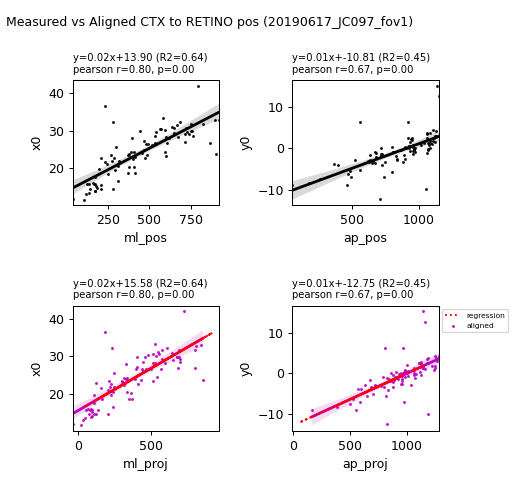

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or mis

Text(0.01, 0.95, 'Measured vs Aligned CTX to RETINO pos (20190617_JC097_fov1)')

In [355]:
#### Align SOMA coords
regr_soma_meas = grd.regress_cortex_and_retino_pos(aligned_soma, 
                                                   xvar='pos', model='ridge')
regr_soma_proj = grd.regress_cortex_and_retino_pos(aligned_soma, 
                                                    xvar='proj', model='ridge')
print("MEASURED:")
print(regr_soma_meas.to_markdown())
print("ALIGNED:")
print(regr_soma_proj.to_markdown())
fig = grd.plot_measured_and_aligned(aligned_soma, regr_soma_proj, regr_soma_meas)
fig.text(0.01, 0.95, 'Measured vs Aligned CTX to RETINO pos (%s)' % dk)

figname = 'compared_measured_vs_aligned_CTX_to_RETINO'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

#### Predict SOMA pos from retino preference

In [286]:
#### Predicted CORTICAL position (from retino position)
p_x = grd.predict_cortex_position(REGR_NP, cond='az', 
                          points=aligned_soma['x0'].values)
p_y = grd.predict_cortex_position(REGR_NP, cond='el', 
                          points=aligned_soma['y0'].values)
aligned_soma['predicted_ml_proj'] = p_x
aligned_soma['predicted_ap_proj'] = p_y

#### Predicted RETINO position (from cortical position)
r_x = grd.predict_retino_position(REGR_NP, cond='az', 
                          points=aligned_soma['ml_proj'].values)
r_y = grd.predict_retino_position(REGR_NP, cond='el', 
                          points=aligned_soma['ap_proj'].values)
aligned_soma['predicted_x0'] = r_x
aligned_soma['predicted_y0'] = r_y

In [287]:
#### Calculate inverse for visualizing on FOV
pred_INV = [np.linalg.inv(M).dot(np.array([x, y])) for (x, y) \
               in aligned_soma[['predicted_ml_proj', 'predicted_ap_proj']].values]
pred_inv_df = pd.DataFrame(pred_INV, columns=['pred_inv_x', 'pred_inv_y'], 
                      index=aligned_soma.index)
aligned_soma['predicted_ml_pos'] = pred_inv_df['pred_inv_x']
aligned_soma['predicted_ap_pos'] = pred_inv_df['pred_inv_y']

# Visualization

In [288]:
zimg, masks, ctrs = roiutils.get_masks_and_centroids(dk, traceid=traceid)
pixel_size = hutils.get_pixel_size()
zimg_r = retutils.transform_2p_fov(zimg, pixel_size)

<IPython.core.display.Javascript object>


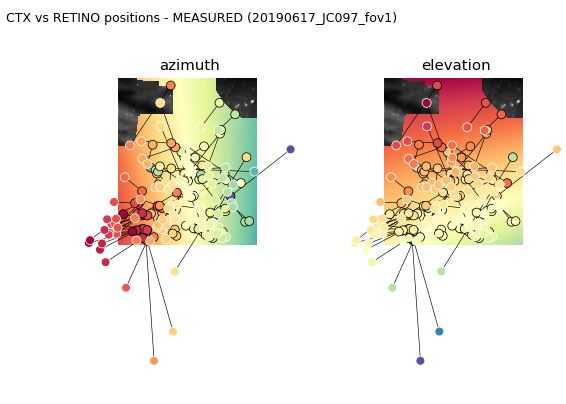

Text(0.01, 0.95, 'CTX vs RETINO positions - MEASURED (20190617_JC097_fov1)')

In [289]:
cmap='Spectral'
plot_true=True
plot_predicted=True
plot_lines=True

markersize=50
lw=0.6
alpha=1

df_ = aligned_soma.copy().reset_index(drop=True)

# Make sure we are in bounds of FOV
max_ypos, max_xpos = AZMAP_NP.shape
incl_plotdf = df_[(df_['predicted_ml_pos']>=0) & (df_['predicted_ml_pos']<=max_xpos)
           & (df_['predicted_ap_proj']>=0) & (df_['predicted_ap_proj']<=max_ypos)].copy()
excl_ixs = [i for i in df_.index.tolist() if i not in incl_plotdf.index]
#plotdf = df_.loc[excl_ixs].copy()
#plotdf = incl_plotdf.iloc[0::].copy()
plotdf=df_.copy()


fig, axn = pl.subplots(1, 2, figsize=(7,5))
for ax, cond in zip(axn, ['azimuth', 'elevation']):
    neuropil_map = AZMAP_NP.copy() if cond=='azimuth' else ELMAP_NP.copy()
    retino_label='x0' if cond=='azimuth' else 'y0'
    # Set color limits
    vmin = min([np.nanmin(neuropil_map), plotdf[retino_label].min()])
    vmax = max([np.nanmax(neuropil_map), plotdf[retino_label].max()])
    normalize = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    ax.set_title(cond)
    ax.imshow(zimg_r, cmap='gray') #, vmin=abs_vmin, vmax=abs_vmax)
    ax.imshow(neuropil_map, cmap=cmap, vmin=vmin, vmax=vmax, alpha=alpha)
    if plot_true:
        # Plot soma
        sns.scatterplot(x='ml_pos', y='ap_pos', data=plotdf, ax=ax,
                alpha=alpha, hue=retino_label, hue_norm=normalize, palette=cmap,
                s=markersize, linewidth=lw, edgecolor='k', zorder=1000) 
    if plot_predicted:
        # Plot soma
        sns.scatterplot(x='predicted_ml_pos', y='predicted_ap_pos', 
                data=plotdf, ax=ax,
                alpha=alpha, hue=retino_label, hue_norm=normalize, palette=cmap,
                s=markersize, linewidth=lw, edgecolor='w', zorder=1000) 
    if plot_lines:
        # Plot connecting line
        for (x1, y1), (x2, y2) in zip(\
                plotdf[['predicted_ml_pos', 'predicted_ap_pos']].values,
                plotdf[['ml_pos', 'ap_pos']].values):
            ax.plot([x1, x2], [y1, y2], lw=0.5, markersize=0, color='k')
for ax in axn:
    ax.legend_.remove()
    ax.axis('off')
    
fig.text(0.01, 0.95, 'CTX vs RETINO positions - MEASURED (%s)' % dk)

# Calculate scatter

<IPython.core.display.Javascript object>


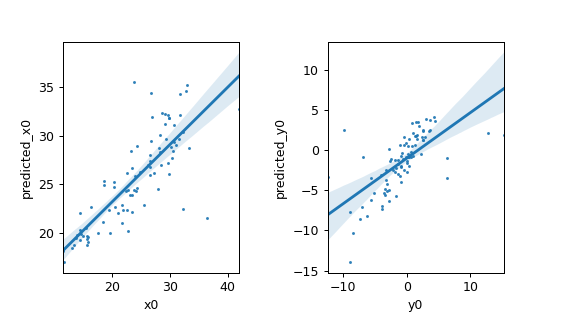

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


In [353]:
fig, axn = pl.subplots(1,2, figsize=(7,4))
ax=axn[0]
sns.regplot('x0', 'predicted_x0', data=aligned_soma, ax=ax, scatter_kws=scatter_kws)
ax=axn[1]
sns.regplot('y0', 'predicted_y0', data=aligned_soma, ax=ax, scatter_kws=scatter_kws)
pl.subplots_adjust(bottom=0.24, right=0.8, left=0.1, hspace=0.5, wspace=0.5)

In [357]:
deviations = grd.get_deviations(aligned_soma)

<IPython.core.display.Javascript object>


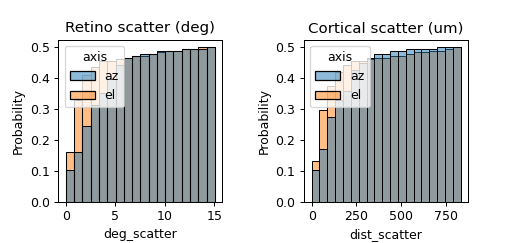

In [359]:
%matplotlib notebook
fig, axn = pl.subplots(1,2, figsize=(6.5, 3))


ax=axn[0]
sns.histplot(deviations, x='deg_scatter', hue='axis', ax=ax,
            stat='probability', cumulative=True )
ax.set_title('Retino scatter (deg)')
ax=axn[1]
sns.histplot(deviations, x='dist_scatter', hue='axis', ax=ax,
            stat='probability', cumulative=True)
ax.set_title('Cortical scatter (um)')
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.25, top=0.85, wspace=0.5, hspace=0.5)
